In [ ]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import scipy.fft as fft
import numpy as np
from matplotlib import pyplot as plt

filepath = Path(r"D:\Messungen\Profilometry\Lasermikroskop\Wetting Ridge\Wetting_Ridge2_5x_smooth\Wetting_Ridge2_5x__profile.csv")

profile = pd.read_csv(filepath, sep=";", skiprows=3, names=["x","y","idk"], index_col=False)

yf = np.abs(fft.rfft(np.asarray(profile["y"], dtype=np.float64)))
xf = fft.rfftfreq(len(profile["y"]),profile["x"][1])

plt.plot(xf,yf,"r-")
plt.xlim(-1000,25000)

plt.show()

plt.plot("x","y", "k.", markersize=2,data=profile)



### Shahannan

https://doi.org/10.1021/la00004a055:   
$
\zeta = \cfrac{\gamma_l\sin\theta}{2\pi G} \ln\left(\frac{d}{|x|}\right)
$  

10.1088/0022-3727/20/7/018:  
$
\nu = 0.5 \rightarrow \\
\varphi = \cfrac{3\gamma_l}{2\pi G} \left[\sin\theta\ln\left(\cfrac{\delta}{x-x_0}\right)\right], \mathrm{inside\ droplet}\\
\zeta = \cfrac{3\gamma_l}{2\pi G} \left[\sin\theta\ln\left(\cfrac{\mu}{x_0-x}\right)\right], \mathrm{outside\ droplet}
$  
$\delta, \mu$: distances at which the deformation can be assumed 0

In [ ]:
from scipy.optimize import curve_fit
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pathlib import Path

filepath = Path(r"D:\Messungen\Profilometry\Lasermikroskop\Wetting Ridge\Wetting_Ridge2_5x_smooth\Wetting_Ridge2_5x__profile_sharp.csv")

thetha = 110
# shear = 14000
d = 0.003#
s_tens = 0.021

# def displacement_far(x, gamma, shear, d):
#     xi = (gamma*np.sin(thetha))/(2*np.pi*shear) * np.log(d/np.abs(x))
#     # xi = np.log(d/np.abs(x))
#     return xi

def displacement_far(x, gamma, d, displ, shft):
    xi = gamma * np.log(d/np.abs(x)-displ) + shft
    # xi = np.log(d/np.abs(x))
    return xi

profile = pd.read_csv(filepath, sep=";", skiprows=3, names=["x","y","idk"], index_col=False)
defl = np.asarray(profile["y"], dtype=np.float64)
x_ax = np.asarray(profile["x"], dtype=np.float64)

peak = np.argmax(defl)

cutoff = 300
defl_inner = np.flip(defl[peak-cutoff:peak-1])
x_ax_inner = x_ax[1:cutoff]

# p0: gamma für PDMS = 21.3 mN/m, shear modulus is ca 14000 Pa
# popt, pcov = curve_fit(displacement_far,x_ax_inner, defl_inner, p0=(0.0213, 14000, 0.003), bounds=([0,1,0],[1,30000,1]))
popt, pcov = curve_fit(displacement_far,x_ax_inner, defl_inner, p0=(1, 0.003,0,0), bounds=([0,0,-np.inf,-np.inf],[np.inf,np.inf,0,np.inf]))


fit_x = np.linspace(0,x_ax_inner.max(),200)
fit_defl = displacement_far(fit_x, *popt)

plt.plot(x_ax_inner,defl_inner,"k.", markersize=2)
plt.plot(fit_x,fit_defl,"r-")

plt.show()


### Limat Symmetric / Asymmetric

3.836550195362702e-06 4.567922661439369e-09 0.0030075367620795808
gamma=0.36, gamma_s=0.0002


(0.0028, 0.0032)

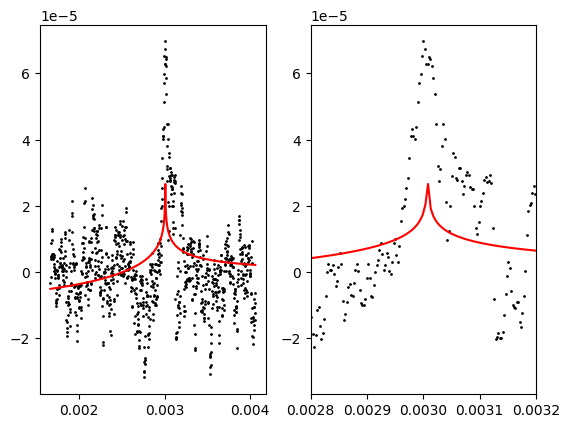

In [5]:
from scipy.optimize import curve_fit
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pathlib import Path

filepath = Path(r"D:\Messungen\Profilometry\Lasermikroskop\Wetting Ridge\Wetting_Ridge2_5x_smooth\Wetting_Ridge2_5x__profile_sharp.csv")

thetha = np.deg2rad(110)
G = 14000
R = 0.003
gamma_s = 0.021 # from 10.1002/marc.202000360
gamma = 0.072 # from https://en.wikipedia.org/wiki/Surface_tension

def zeta_symmetric(x, l_l, l_s, R):
    ls_R = l_s/R

    def smaller_r(x):
        return l_l * (ls_R*np.log((l_s+x+R)/l_s) + ls_R*np.log((l_s-x+R)/l_s) + (x/R)*np.log((l_s+x+R)/(l_s-x+R)) - 2)
    
    def at_r(x):
        return l_l * np.log(x/l_s)

    def larger_r(x):
        return l_l * (((x+l_s)/R)*np.log((l_s+x+R)/(l_s+x-R)) - 2)
    
    zeta = x.copy()
    zeta[x<R] = smaller_r(x[x<R])
    zeta[x==R] = at_r(x[x==R])
    zeta[x>R] = larger_r(x[x>R])
    
    return zeta


profile = pd.read_csv(filepath, sep=";", skiprows=3, names=["x","y","idk"], index_col=False)
defl = np.asarray(profile["y"], dtype=np.float64)[1:]
x_ax = np.asarray(profile["x"], dtype=np.float64)[1:]

peak = np.argmax(defl)
x_ax += R - x_ax[peak]

cutoff = 300

l_l_guess = gamma*np.sin(thetha)/(2*np.pi*G)
l_s_guess = gamma_s/(np.pi*G)


popt, pcov = curve_fit(zeta_symmetric,x_ax, defl, p0=(l_l_guess, l_s_guess, 0.003), bounds=([0,0,0],[np.inf,np.inf,np.inf]))
print(*popt)
print(f"gamma={popt[0]*14000*2*np.pi/np.sin(thetha):.2g}, gamma_s={popt[1]*14000*np.pi:.2g}")

fit_x = np.linspace(x_ax.min(),x_ax.max(),500)
fit_defl = zeta_symmetric(fit_x, *popt)

ax = plt.subplot(1,2,1)

ax.plot(x_ax,defl,"k.", markersize=2)
ax.plot(fit_x,fit_defl,"r-")

# plt.show()
ax = plt.subplot(1,2,2)

ax.plot(x_ax,defl,"k.", markersize=2)
ax.plot(fit_x,fit_defl,"r-")
plt.xlim(0.0028,0.0032)

In [ ]:
# limat asymm
from scipy.optimize import curve_fit
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pathlib import Path

filepath = Path(r"D:\Messungen\Profilometry\Lasermikroskop\Wetting Ridge\Wetting_Ridge2_5x_smooth\Wetting_Ridge2_5x__profile_sharp.csv")

thetha = 110
G = 14000
R = 0.003
gamma_s = 0.021 # from 10.1002/marc.202000360
gamma = 0.072 # from https://en.wikipedia.org/wiki/Surface_tension
# -(a (b sgn(x - z)))/((abs(z) + b) (b + abs(x - z))) dx = -(a b (b - rsgn(z)) (sgn(x - z) (log(b + x - z) - log(b - x + z)) + log(b + x - z) + log(b - x + z)))/(2 (b - z) (b + z))

def zeta_symmetric(x, l_l, l_s):
    ls_R = l_s/R

    def smaller_r(x):
        return l_l * (ls_R*np.log((l_s+x+R)/l_s) + ls_R*np.log((l_s-x+R)/l_s) + (x/R)*np.log((l_s+x+R)/(l_s-x+R)) - 2)
    
    def at_r(x):
        return l_l * np.log(x/l_s)

    def larger_r(x):
        return l_l * (((x+l_s)/R)*np.log((l_s+x+R)/(l_s+x-R)) - 2)
    
    zeta = x.copy()
    zeta[x<R] = smaller_r(x[x<R])
    zeta[x==R] = at_r(x[x==R])
    zeta[x>R] = larger_r(x[x>R])
    
    return zeta

def zeta_asymmetric(x, zeta_der, l_l, l_s, l_d):
    # https://www.wolframalpha.com/input?i=Integrate%5B-%28a+%28%28b%2F%28Abs%5Bx%5D+%2B+b%29%29+%28Sign%5Br+-+x%5D%2F%28b+%2B+Abs%5Br+-+x%5D%29%29%29%29%2C+r%5D
    def correction_integr(r):
        return -(zeta_der * l_s * (l_s - x*np.sign(x)) * (np.sign(r-x) * (np.log(l_s+r-x) - np.log(l_s-r+x)) + np.log(l_s+r-x) + np.log(l_s-r+x)))/(2*(l_s-x)*(l_s+x))
    
    def correction():
        return (correction_integr(R) - correction_integr(-R)) * l_d
    
    return zeta_symmetric(x, l_l, l_s) + correction()

profile = pd.read_csv(filepath, sep=";", skiprows=3, names=["x","y","idk"], index_col=False)
defl = np.asarray(profile["y"], dtype=np.float64)[1:]
x_ax = np.asarray(profile["x"], dtype=np.float64)[1:]

peak = np.argmax(defl)
x_ax += R - x_ax[peak]

cutoff = 300

zeta_der_guess = gamma*np.sin(thetha)/gamma_s
l_l_guess = np.abs(gamma*np.sin(thetha)/(2*np.pi*G))
l_s_guess = gamma_s/(np.pi*G)
l_d_guess = (gamma_s/(2*np.pi*G)) # gamma_delta ~ gamma_sl - gamma_s, but gamma_sl is unknown

test = zeta_symmetric(x_ax, l_l_guess, l_s_guess)

popt, pcov = curve_fit(zeta_asymmetric,x_ax, defl, p0=(zeta_der_guess, l_l_guess, l_s_guess, l_d_guess), bounds=([-np.inf,0,0,0],[np.inf,np.inf,np.inf,np.inf]))
print(*popt)
print(f"gamma={popt[0]*14000*2*np.pi/np.abs(np.sin(thetha)):.2g}, gamma_s={popt[1]*14000*np.pi:.2g}")

fit_x = np.linspace(x_ax.min(),x_ax.max(),500)
fit_defl = zeta_asymmetric(fit_x, *popt)

plt.plot(x_ax,defl,"k.", markersize=2)
plt.plot(fit_x,fit_defl,"r-")

plt.show()

plt.plot(x_ax,defl,"k.", markersize=2)
plt.plot(fit_x,fit_defl,"r-")
plt.xlim(0.0028,0.0032)

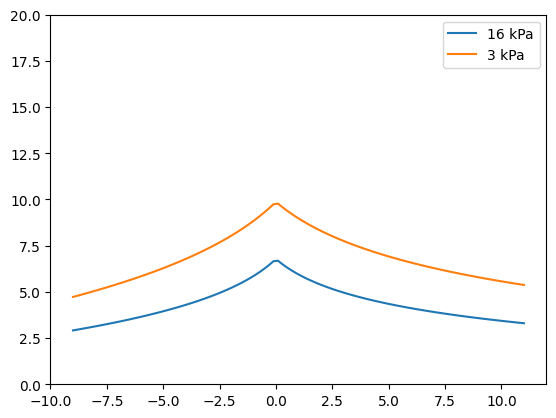

In [94]:
# confirm limat from xray paper
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pathlib import Path

def zeta_symmetric(x, l_l, l_s, R):
    ls_R = l_s/R

    def smaller_r(x):
        return l_l * (ls_R*np.log((l_s+x+R)/l_s) + ls_R*np.log((l_s-x+R)/l_s) + (x/R)*np.log((l_s+x+R)/(l_s-x+R)) - 2)
    
    def at_r(x):
        return l_l * np.log(x/l_s)

    def larger_r(x):
        return l_l * (((x+l_s)/R)*np.log((l_s+x+R)/(l_s+x-R)) - 2)
    
    zeta = x.copy()
    zeta[x<R] = smaller_r(x[x<R])
    zeta[x==R] = at_r(x[x==R])
    zeta[x>R] = larger_r(x[x>R])
    
    return zeta

R = 0.0002
gamma_s = 0.031 # from 10.1002/marc.202000360
gamma = 0.072 # from https://en.wikipedia.org/wiki/Surface_tension
theta = np.deg2rad(106)


G = 17000/3
l_l = gamma*np.sin(theta) / (2*np.pi*G)
l_s = gamma_s / (np.pi*G)

x_ax = np.linspace(R-0.000009, R+0.000011,100)
zeta = zeta_symmetric(x_ax, l_l, l_s, R)

plt.plot((x_ax-R)*1e6,zeta*1e6, label="16 kPa")

G = 10000/3
l_l = gamma*np.sin(theta) / (2*np.pi*G)
l_s = gamma_s / (np.pi*G)

x_ax = np.linspace(R-0.000009, R+0.000011,100)
zeta = zeta_symmetric(x_ax, l_l, l_s, R)

plt.plot((x_ax-R)*1e6,zeta*1e6, label="3 kPa" )
plt.ylim(0,20)

plt.legend()
plt.show()
